In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!pip install gensim tensorflow pandas scikit-learn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

In [22]:
import pandas as pd

# Example for a CSV file
df = pd.read_csv('/content/drive/My Drive/ttrain.csv')
df_test = pd.read_csv('/content/drive/My Drive/ttest.csv')


In [23]:

df['comment']=df['cleaned_comment']
df_test['comment']=df_test['cleaned_comment']

In [24]:

# Drop rows where 'comment' is null
df = df[df['comment'].notnull()]

# Drop duplicate values in the 'comment' column
df = df.drop_duplicates(subset='comment')

# Reset index after dropping rows (optional)
df = df.reset_index(drop=True)


# Drop rows where 'comment' is null
df_test = df_test[df_test['comment'].notnull()]

# Drop duplicate values in the 'comment' column
df_test = df_test.drop_duplicates(subset='comment')

# Reset index after dropping rows (optional)
df_test = df_test.reset_index(drop=True)


In [29]:
df['nlabel'] = df['nlabel'].replace({2: 0})
#df_test['nlabel'] = df_test['nlabel'].replace({2: 0})
# Replace specific label values with 0 in df_test['nlabel']
df_test['nlabel'] = df_test['nlabel'].replace({2: 0, 3: 0, 4: 0, 5: 0})


In [30]:

df_test

,comment,nlabel,cleaned_comment
0,বয়কট করলাম,1,বয়কট করলাম
1,সালা পাগোল চোদা নায়ক,0,সালা পাগোল চোদা নায়ক
2,প্রশ্ন জন্মদাতা আছে নাকি এমনেই দুনিয়াতে আসছে ত...,0,প্রশ্ন জন্মদাতা আছে নাকি এমনেই দুনিয়াতে আসছে ত...
3,নাটোরের বনলতাসেন বড়াইগ্রামের অহংকার,1,নাটোরের বনলতাসেন বড়াইগ্রামের অহংকার
4,সাফা বলেছে বিশ্বাস পরকাল বিশ্বাস উনার বাবা আছে...,0,সাফা বলেছে বিশ্বাস পরকাল বিশ্বাস উনার বাবা আছে...
...,...,...,...
8436,কবরে হুতার কয়কটা রডের বাড়ি খাইলে বিশ্বাস অইবো ...,0,কবরে হুতার কয়কটা রডের বাড়ি খাইলে বিশ্বাস অইবো ...
8437,কামলা প্রসঙ্গের কথা যাচ্ছে,0,কামলা প্রসঙ্গের কথা যাচ্ছে
8438,হাগল,0,হাগল
8439,ওরে লুতু লুতু পুতু পুতু বাবুটা আল্লাহ্‌র মাফ চ...,0,ওরে লুতু লুতু পুতু পুতু বাবুটা আল্লাহ্‌র মাফ চ...


MAIN EMBEDDING

In [31]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

# Assuming df['comment'] is cleaned text and df['label'] is categorical labels

# Step 1: Tokenize and preprocess the text data
comments = df['comment'].values
labels = df['nlabel'].values
labels = to_categorical(labels)  # One-hot encoding for labels

# Step 2: Create Word2Vec model to embed the text data
tokenized_comments = [comment.split() for comment in comments]
word2vec_model = Word2Vec(sentences=tokenized_comments, vector_size=30, window=5, min_count=1, workers=4)

# Step 3: Prepare embedding matrix
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 30))
for word, idx in word2vec_model.wv.key_to_index.items():
    embedding_vector = word2vec_model.wv[word]
    embedding_matrix[idx] = embedding_vector

# Step 4: Tokenize the comments to integer sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
X = pad_sequences(sequences, padding='post')

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

comments_test = df_test['comment'].values
labels_test = df_test['nlabel'].values

# Step 2: Tokenize and convert the test comments to sequences
sequences_test = tokenizer.texts_to_sequences(comments_test)
XX_test = pad_sequences(sequences_test, padding='post', maxlen=X.shape[1])  # Same maxlen as training data

# Step 3: One-hot encode the test labels
yy_test = to_categorical(labels_test, num_classes=y_train.shape[1])

BI-LSTM

In [32]:
# Step 6: Build BiLSTM model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=30, weights=[embedding_matrix], input_length=X_train.shape[1], trainable=False))
#model.add(Dropout(0.3))  # Dropout in dense layers

model.add(Bidirectional(LSTM(64)))
#model.add(Dropout(0.2))  # Dropout in dense layers

model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.3))  # Dropout in dense layers

model.add(Dense(y_train.shape[1], activation='sigmoid'))

# Step 7: Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Step 8: Train the model
history=model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 9: Evaluate the model
loss, accuracy = model.evaluate(XX_test, yy_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1045/1045 ━━━━━━━━━━━━━━━━━━━━ 51s 22ms/step - accuracy: 0.6422 - loss: 0.6065 - val_accuracy: 0.7140 - val_loss: 0.5294
Epoch 2/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.7145 - loss: 0.5200 - val_accuracy: 0.7235 - val_loss: 0.5018
Epoch 3/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.7385 - loss: 0.4921 - val_accuracy: 0.7400 - val_loss: 0.4897
Epoch 4/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.7440 - loss: 0.4797 - val_accuracy: 0.7404 - val_loss: 0.4862
Epoch 5/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7508 - loss: 0.4683 - val_accuracy: 0.7417 - val_loss: 0.4801
Epoch 6/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.7621 - loss: 0.4577 - val_accuracy: 0.7586 - val_loss: 0.4656
Epoch 7/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.7649 - loss: 0.4498 - val_accuracy: 0.7575 - val_loss: 0.4686
Epoch 8/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.7794 - loss: 0.43

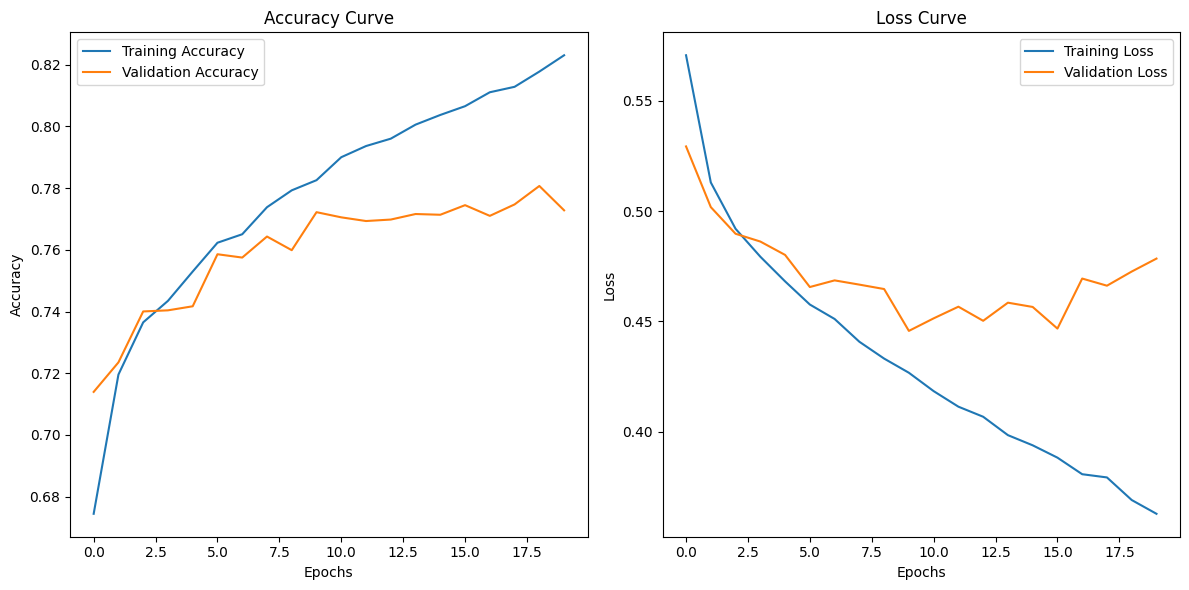

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
from sklearn.metrics import classification_report
# Step 10: Predict and calculate precision, recall, F1 score
y_pred = model.predict(XX_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot predictions to class labels
y_true_classes = np.argmax(yy_test, axis=1)  # Convert one-hot ground truth to class labels

# Generate a classification report
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Accuracy: 0.7439

Classification Report:

              precision    recall  f1-score   support

           0     0.8886    0.6999    0.7831      5575
           1     0.5869    0.8294    0.6874      2866

    accuracy                         0.7439      8441
   macro avg     0.7378    0.7646    0.7352      8441
weighted avg     0.7862    0.7439    0.7506      8441



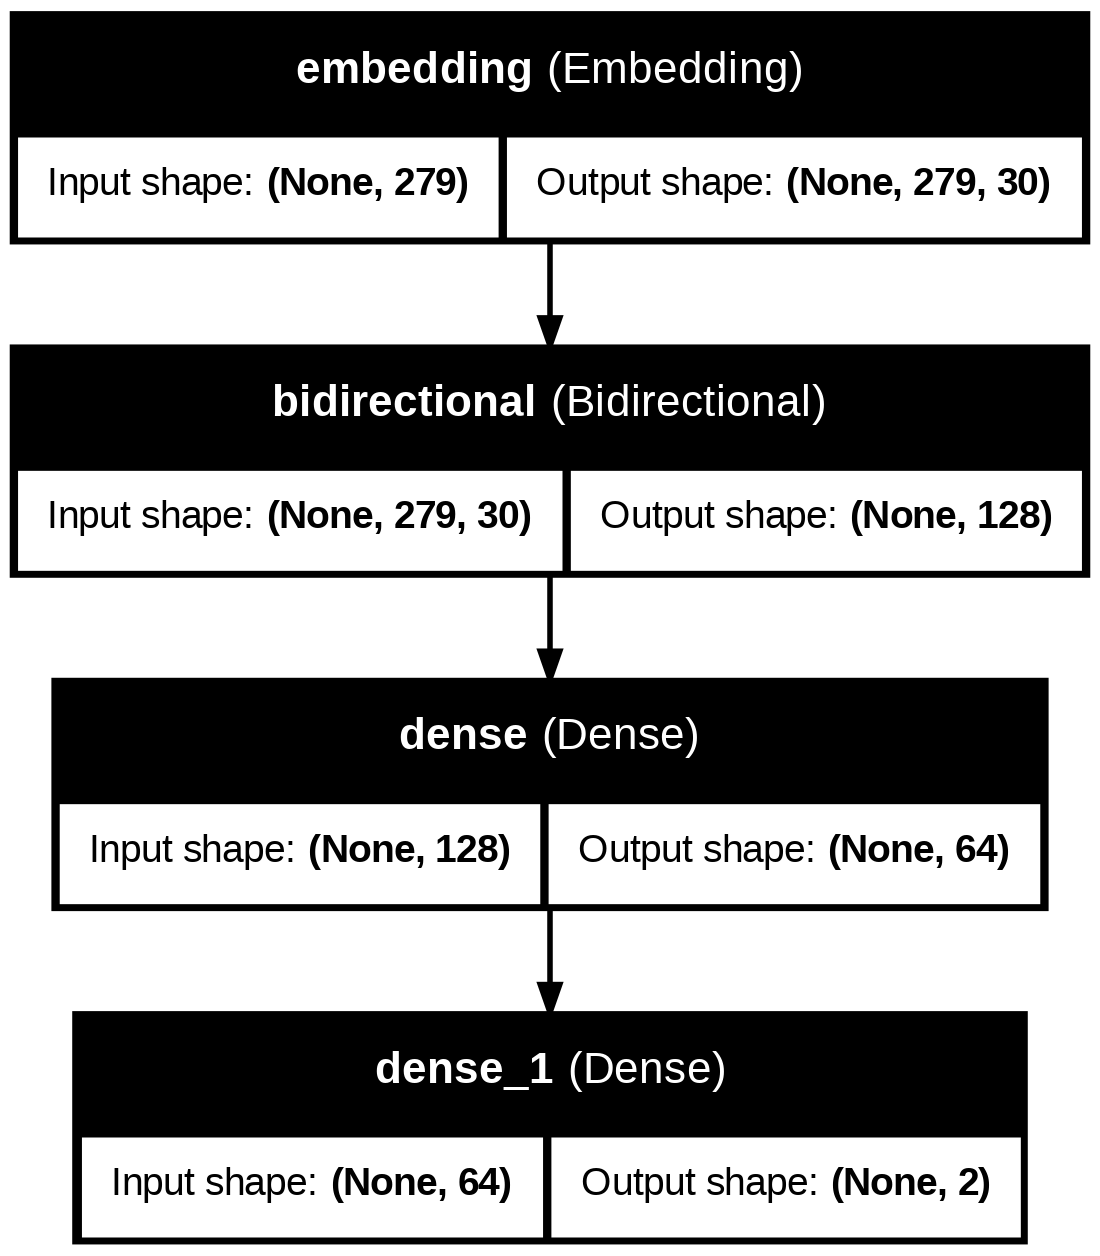

In [ ]:
from tensorflow.keras.utils import plot_model  # Import plot_model function

plot_model(model, to_file='model_bilstm.png', show_shapes=True, show_layer_names=True)


CNN-LSTM

In [35]:
# Step 6: Build CNN-LSTM model

from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0],
                    output_dim=30,
                    weights=[embedding_matrix],
                    input_length=X_train.shape[1],
                    trainable=False))  # Pre-trained embedding
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))  # Adjusted kernel size and filters
model.add(LSTM(100, return_sequences=True))  # Adjusted LSTM units to 100
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))  # Fully connected layer
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Output layer

# Step 7: Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 8: Train the model
history=model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))  # Increased epochs and decreased batch size

# Step 9: Evaluate the model
loss, accuracy = model.evaluate(XX_test, yy_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1045/1045 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.5906 - loss: 0.6536 - val_accuracy: 0.6734 - val_loss: 0.5854
Epoch 2/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6751 - loss: 0.5724 - val_accuracy: 0.6882 - val_loss: 0.5506
Epoch 3/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6929 - loss: 0.5483 - val_accuracy: 0.6991 - val_loss: 0.5400
Epoch 4/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7091 - loss: 0.5291 - val_accuracy: 0.7167 - val_loss: 0.5184
Epoch 5/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.7227 - loss: 0.5172 - val_accuracy: 0.7235 - val_loss: 0.5113
Epoch 6/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7308 - loss: 0.5042 - val_accuracy: 0.7295 - val_loss: 0.4966
Epoch 7/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7424 - loss: 0.4856 - val_accuracy: 0.7293 - val_loss: 0.5031
Epoch 8/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7443 - loss: 0.48

In [36]:
from sklearn.metrics import classification_report
# Step 10: Predict and calculate precision, recall, F1 score
y_pred = model.predict(XX_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot predictions to class labels
y_true_classes = np.argmax(yy_test, axis=1)  # Convert one-hot ground truth to class labels
print(f"Accuracy: {accuracy:.4f}")
# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.7267

Classification Report:

              precision    recall  f1-score   support

           0     0.8695    0.6897    0.7692      5575
           1     0.5695    0.7987    0.6649      2866

    accuracy                         0.7267      8441
   macro avg     0.7195    0.7442    0.7171      8441
weighted avg     0.7677    0.7267    0.7338      8441



CNN-GRU Model

In [37]:
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling1D, GRU
from tensorflow.keras.optimizers import Adam

# Define optimizer
optimizer = Adam(learning_rate=0.005)

# Step 6: Build CNN-GRU model
model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0],
                    output_dim=30,
                    weights=[embedding_matrix],
                    input_length=X_train.shape[1],
                    trainable=False))  # Pre-trained embedding
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'))  # Adjusted kernel size and filters
model.add(GRU(100, return_sequences=True))  # GRU with 100 units
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))  # Fully connected layer
model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Output layer

# Step 7: Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Step 8: Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))  # Increased epochs and decreased batch size

# Step 9: Evaluate the model
loss, accuracy = model.evaluate(XX_test, yy_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1045/1045 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.6080 - loss: 0.6398 - val_accuracy: 0.6858 - val_loss: 0.5669
Epoch 2/15
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.6841 - loss: 0.5640 - val_accuracy: 0.6990 - val_loss: 0.5366
Epoch 3/15
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7043 - loss: 0.5324 - val_accuracy: 0.7143 - val_loss: 0.5315
Epoch 4/15
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7137 - loss: 0.5227 - val_accuracy: 0.7132 - val_loss: 0.5246
Epoch 5/15
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7233 - loss: 0.5039 - val_accuracy: 0.7234 - val_loss: 0.5025
Epoch 6/15
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.7301 - loss: 0.4976 - val_accuracy: 0.7265 - val_loss: 0.5015
Epoch 7/15
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.7407 - loss: 0.4871 - val_accuracy: 0.7382 - val_loss: 0.4903
Epoch 8/15
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7392 - loss: 0.48

In [38]:
from sklearn.metrics import classification_report
# Step 10: Predict and calculate precision, recall, F1 score
y_pred = model.predict(XX_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot predictions to class labels
y_true_classes = np.argmax(yy_test, axis=1)  # Convert one-hot ground truth to class labels
print(f"Accuracy: {accuracy:.4f}")
# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.7234

Classification Report:

              precision    recall  f1-score   support

           0     0.8514    0.7040    0.7707      5575
           1     0.5693    0.7610    0.6513      2866

    accuracy                         0.7234      8441
   macro avg     0.7104    0.7325    0.7110      8441
weighted avg     0.7556    0.7234    0.7302      8441



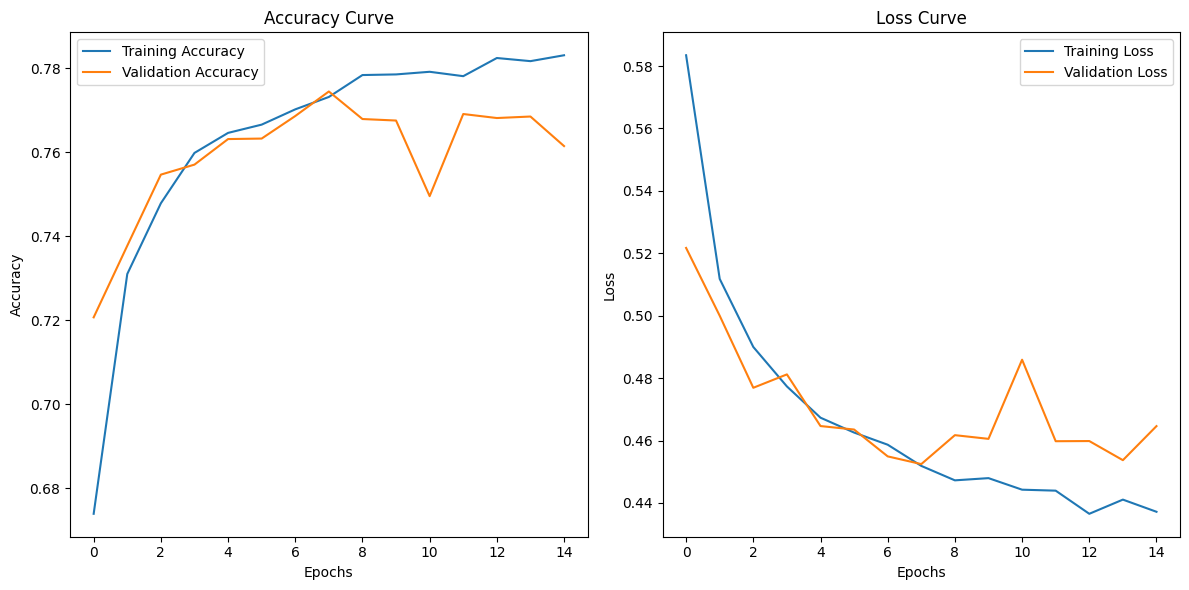

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

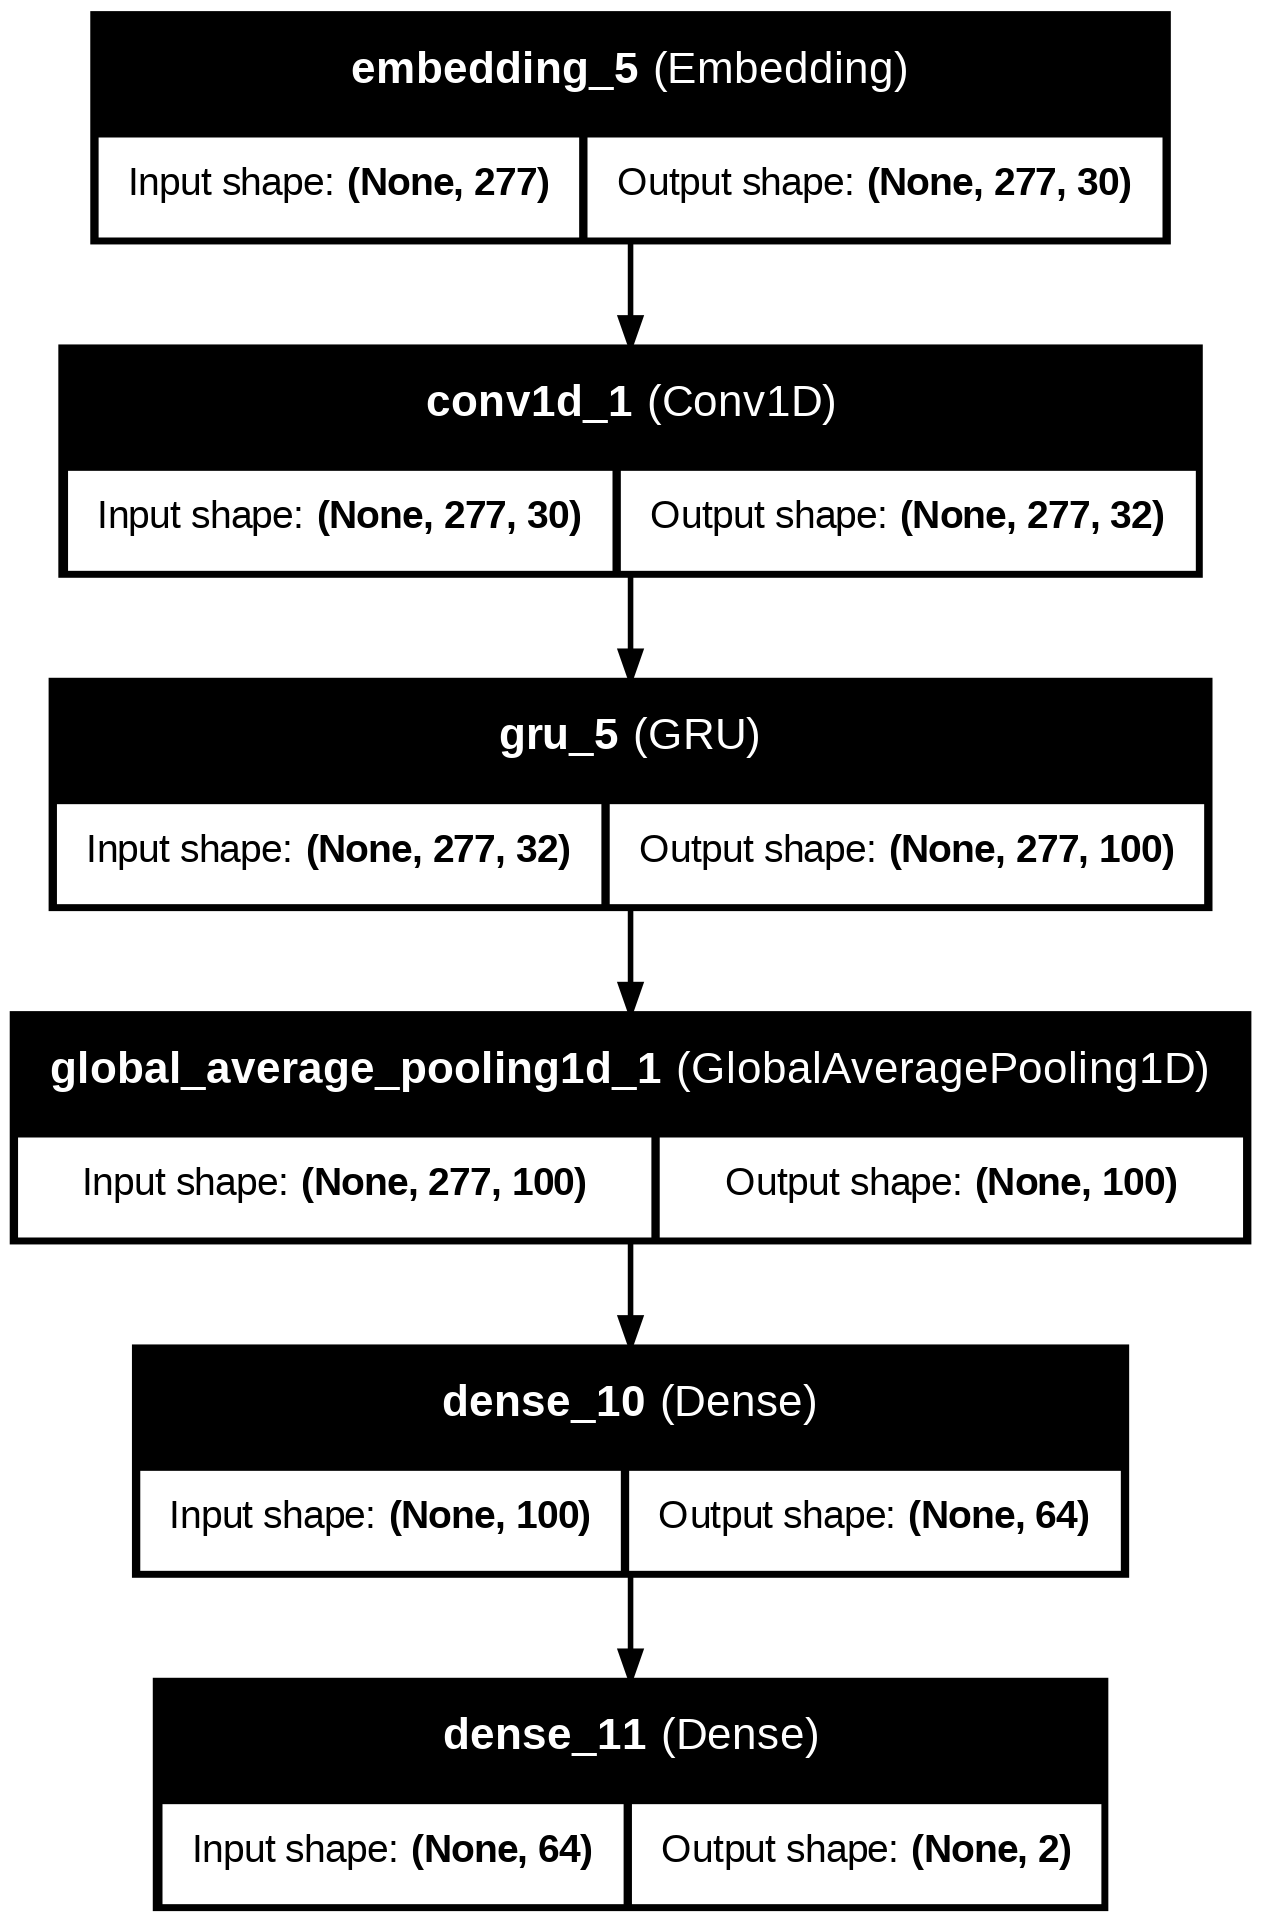

In [19]:
from tensorflow.keras.utils import plot_model  # Import plot_model function

plot_model(model, to_file='model_cnn_fft.png', show_shapes=True, show_layer_names=True)

LSTM+GRU


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

# Define optimizer
optimizer = Adam(learning_rate=0.005)

# Initialize the model
model = Sequential()

# Step 1: Add Embedding Layer
# Assuming embedding_matrix is pre-trained and X_train contains tokenized input
model.add(Embedding(input_dim=embedding_matrix.shape[0],
                    output_dim=30,
                    weights=[embedding_matrix],
                    input_length=X_train.shape[1],
                    trainable=False))

# Step 2: Add a Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Output sequence required for next GRU layer

# Step 3: Add a GRU Layer
model.add(GRU(32))  # A GRU layer after LSTM

# Step 4: Dense Layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout for regularization

# Step 5: Output Layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Step 6: Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Step 7: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Step 8: Evaluate the model
loss, accuracy = model.evaluate(XX_test, yy_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


Epoch 1/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.5116 - loss: 0.6972 - val_accuracy: 0.5190 - val_loss: 0.6926
Epoch 2/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.5202 - loss: 0.6926 - val_accuracy: 0.5190 - val_loss: 0.6929
Epoch 3/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.5114 - loss: 0.6934 - val_accuracy: 0.5190 - val_loss: 0.6936
Epoch 4/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.5211 - loss: 0.6926 - val_accuracy: 0.5190 - val_loss: 0.6926
Epoch 5/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.5202 - loss: 0.6925 - val_accuracy: 0.5190 - val_loss: 0.6924
Epoch 6/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - accuracy: 0.5185 - loss: 0.6927 - val_accuracy: 0.5190 - val_loss: 0.6928
Epoch 7/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.5167 - loss: 0.6925 - val_accuracy: 0.4810 - val_loss: 0.6933
Epoch 8/20
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.5174 -

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report
# Step 10: Predict and calculate precision, recall, F1 score
y_pred = model.predict(XX_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot predictions to class labels
y_true_classes = np.argmax(yy_test, axis=1)  # Convert one-hot ground truth to class labels
print(f"Accuracy: {accuracy:.4f}")
# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Accuracy: 0.6546

Classification Report:

              precision    recall  f1-score   support

           0     0.6546    1.0000    0.7912      5685
           1     0.0000    0.0000    0.0000      3000

    accuracy                         0.6546      8685
   macro avg     0.3273    0.5000    0.3956      8685
weighted avg     0.4285    0.6546    0.5179      8685



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


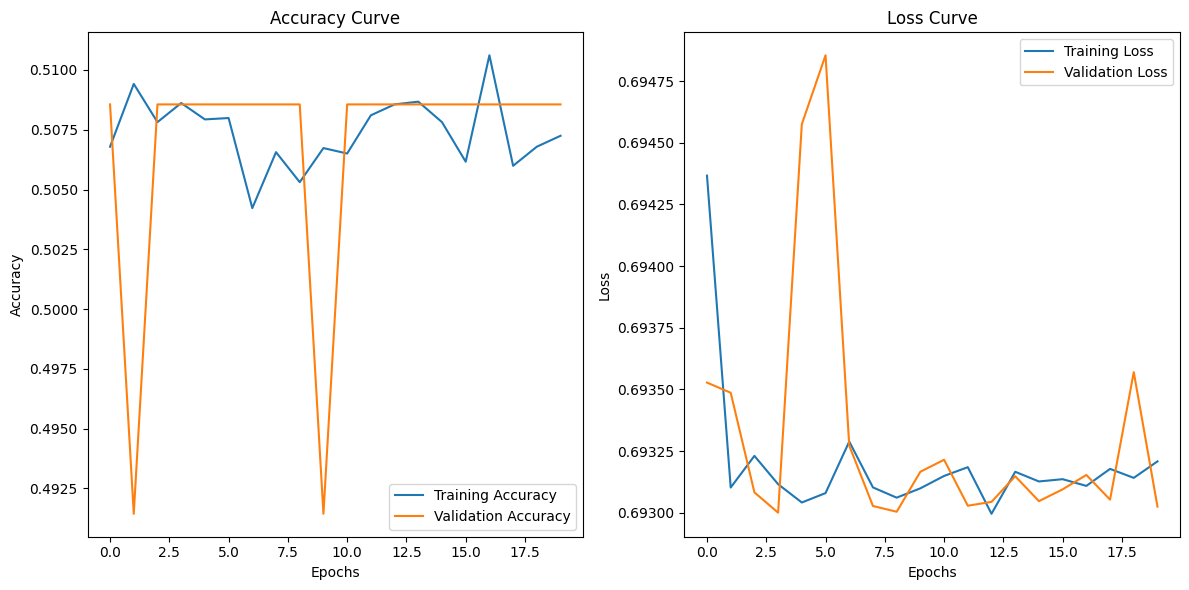

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

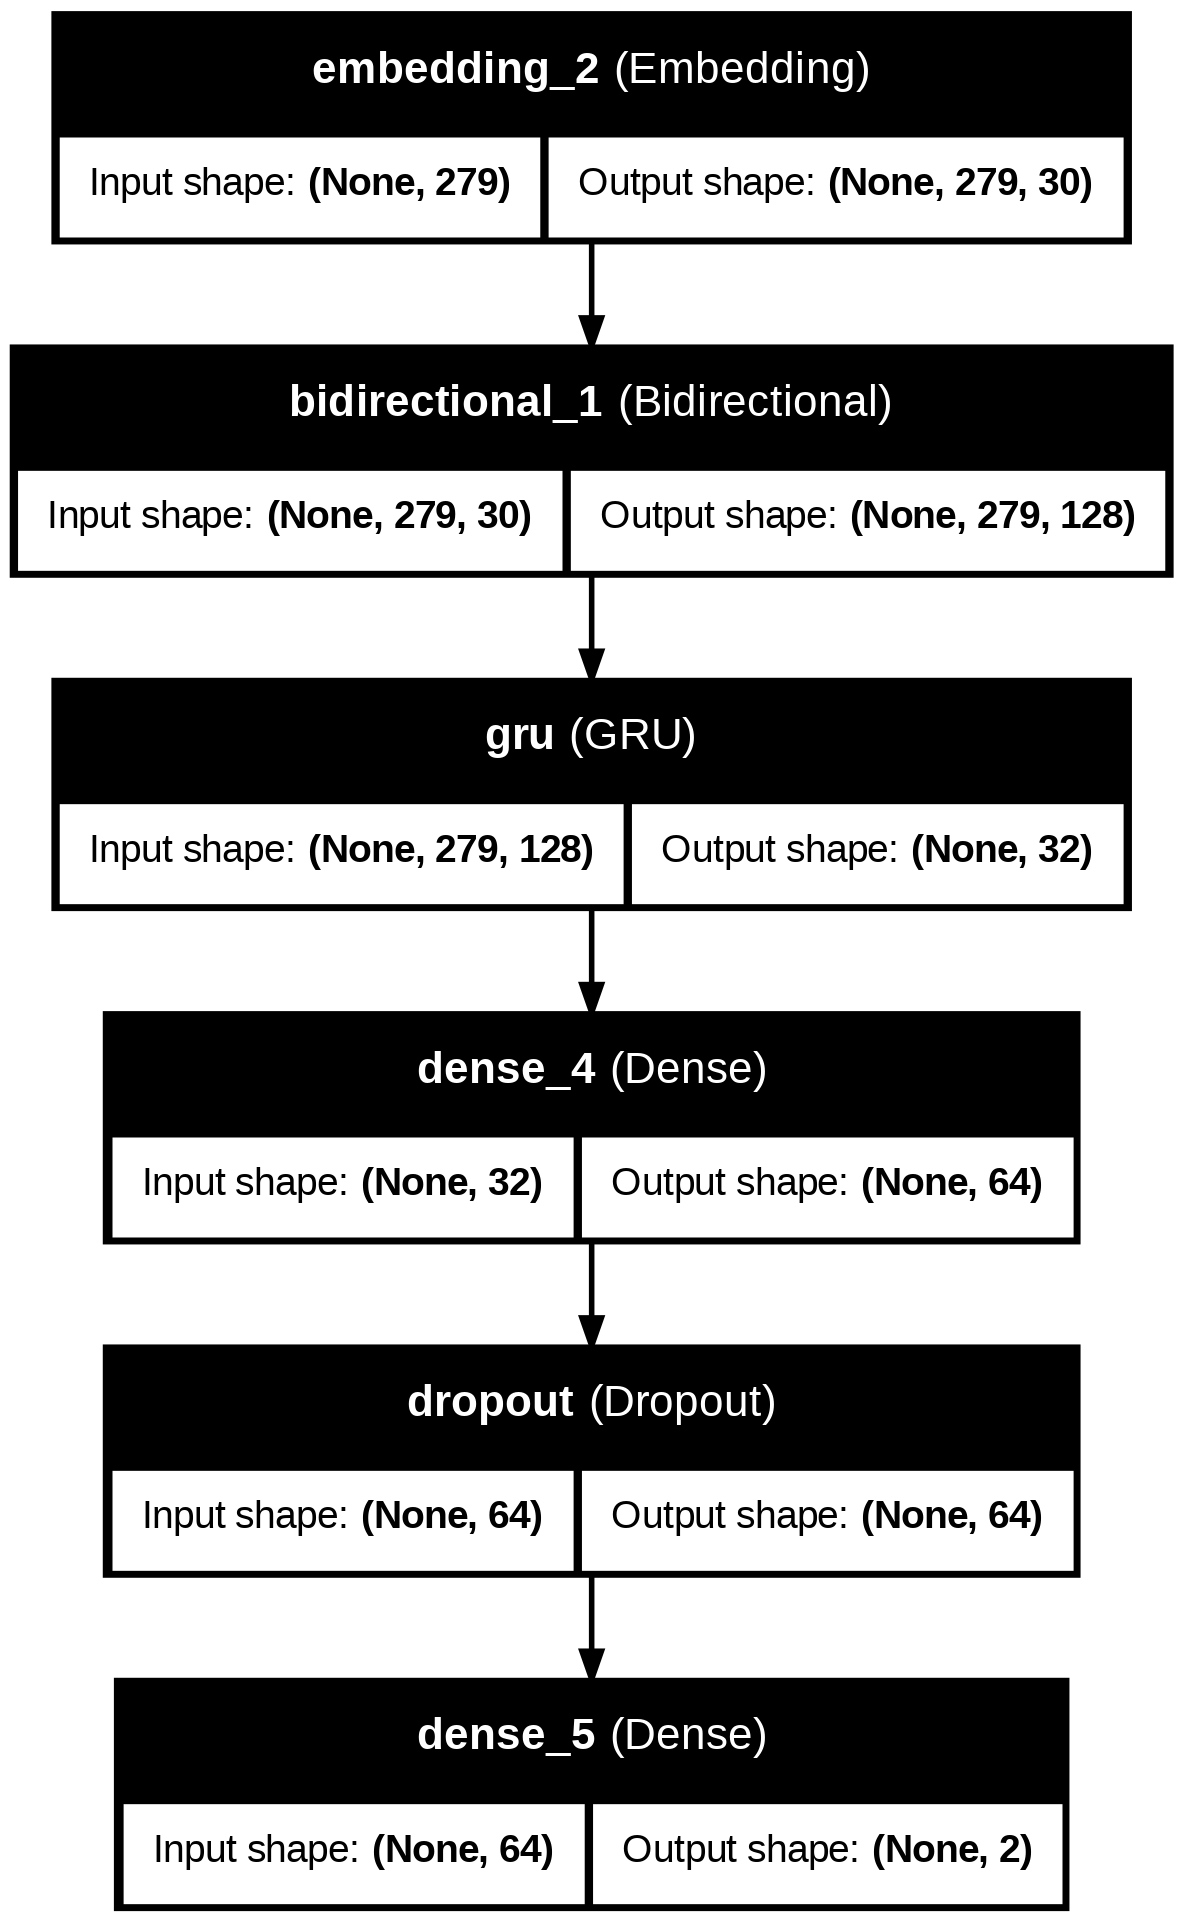

In [ ]:
from tensorflow.keras.utils import plot_model  # Import plot_model function

plot_model(model, to_file='model_cnn_lstm.png', show_shapes=True, show_layer_names=True)

GRU-LSTM

In [41]:
# GRU-LSTM Model
from tensorflow.keras.layers import GRU, LSTM

# Build the GRU-LSTM model
model_gru_lstm = Sequential()
model_gru_lstm.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=30, weights=[embedding_matrix], input_length=X.shape[1], trainable=False))
model_gru_lstm.add(GRU(64, return_sequences=True))  # GRU layer first
model_gru_lstm.add(LSTM(64))  # LSTM layer follows
model_gru_lstm.add(Dense(64, activation='relu'))
model_gru_lstm.add(Dense(y_train.shape[1], activation='sigmoid'))

# Compile the model
model_gru_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history=model_gru_lstm.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss_gru_lstm, accuracy_gru_lstm = model_gru_lstm.evaluate(XX_test, yy_test)
print(f'Loss (GRU-LSTM): {loss_gru_lstm}, Accuracy (GRU-LSTM): {accuracy_gru_lstm}')


Epoch 1/25
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.5652 - loss: 0.6665 - val_accuracy: 0.6715 - val_loss: 0.5913
Epoch 2/25
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 24s 23ms/step - accuracy: 0.7052 - loss: 0.5401 - val_accuracy: 0.7210 - val_loss: 0.5078
Epoch 3/25
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.7247 - loss: 0.5080 - val_accuracy: 0.7265 - val_loss: 0.5044
Epoch 4/25
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7310 - loss: 0.4947 - val_accuracy: 0.7349 - val_loss: 0.4910
Epoch 5/25
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.7374 - loss: 0.4834 - val_accuracy: 0.7406 - val_loss: 0.4787
Epoch 6/25
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.7454 - loss: 0.4743 - val_accuracy: 0.7408 - val_loss: 0.4831
Epoch 7/25
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.7548 - loss: 0.4640 - val_accuracy: 0.7363 - val_loss: 0.4858
Epoch 8/25
1045/1045 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.7606 -

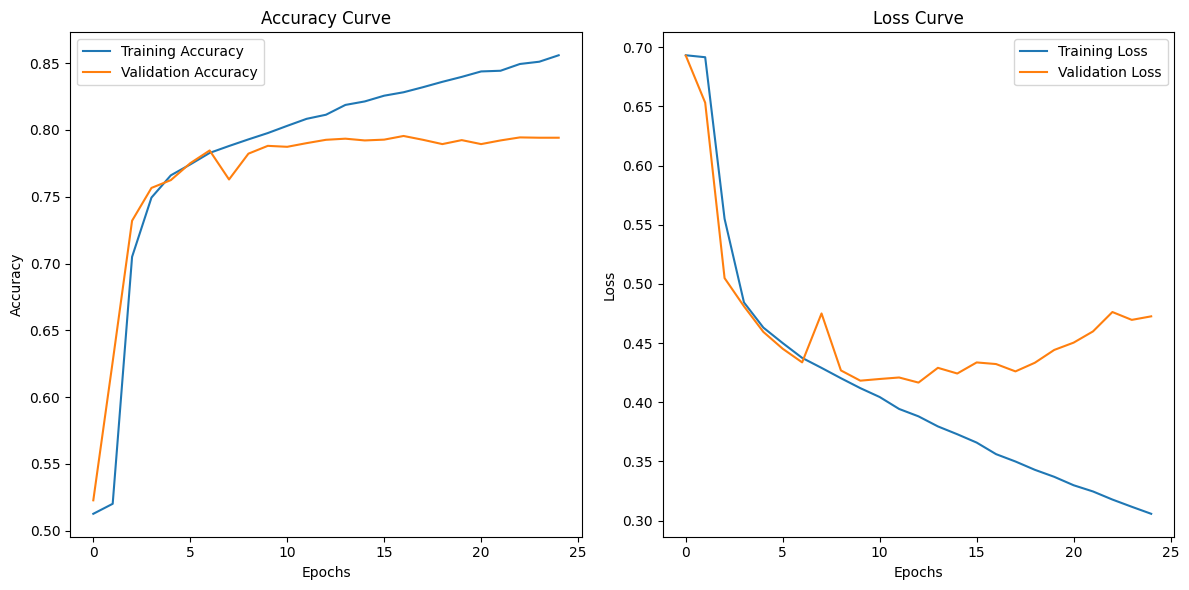

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
from sklearn.metrics import classification_report
# Step 10: Predict and calculate precision, recall, F1 score
loss, accuracy = model_gru_lstm.evaluate(XX_test, yy_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')
y_pred = model_gru_lstm.predict(XX_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot predictions to class labels
y_true_classes = np.argmax(yy_test, axis=1)  # Convert one-hot ground truth to class labels
print(f"Accuracy: {accuracy:.4f}")
# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7189 - loss: 0.5589
Loss: 0.5588698387145996, Accuracy: 0.7124748229980469
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Accuracy: 0.7125

Classification Report:

              precision    recall  f1-score   support

           0     0.9195    0.6188    0.7398      5575
           1     0.5468    0.8946    0.6788      2866

    accuracy                         0.7125      8441
   macro avg     0.7332    0.7567    0.7093      8441
weighted avg     0.7930    0.7125    0.7191      8441



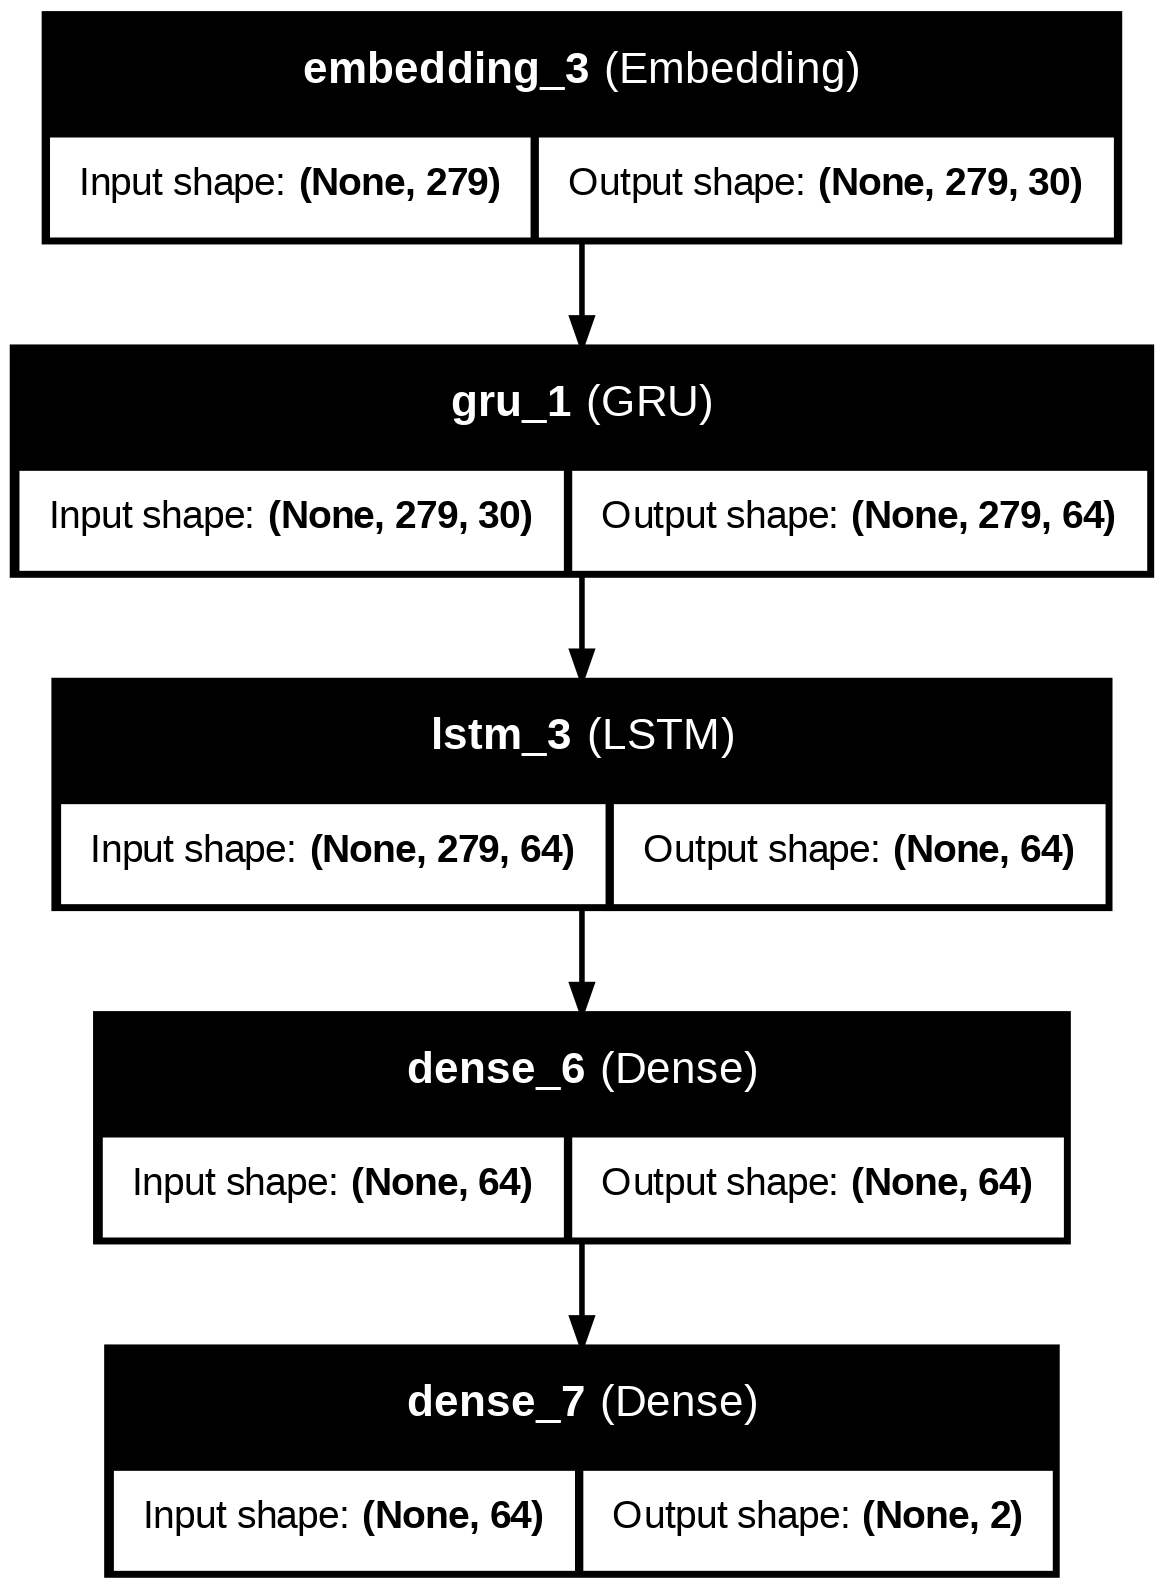

In [ ]:
from tensorflow.keras.utils import plot_model  # Import plot_model function

plot_model(model_gru_lstm, to_file='model_gru_lstm.png', show_shapes=True, show_layer_names=True)

CNN-LSTM-GRU MODEL - NOT DONE YET


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.models import Sequential
import numpy as np

# Build the CNN-LSTM-GRU model
model_cnn_lstm_gru = Sequential()

# Embedding layer with pre-trained Word2Vec embeddings
model_cnn_lstm_gru.add(Embedding(input_dim=embedding_matrix.shape[0],
                                 output_dim=30,
                                 weights=[embedding_matrix],
                                 input_length=X.shape[1],
                                 trainable=False))

# Add CNN layer (1D convolutional layer)
model_cnn_lstm_gru.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_cnn_lstm_gru.add(MaxPooling1D(pool_size=2))  # Pooling layer to reduce dimensionality

# Add LSTM layer
model_cnn_lstm_gru.add(LSTM(64, return_sequences=True))

# Add GRU layer
model_cnn_lstm_gru.add(GRU(64))

# Dense fully connected layer
model_cnn_lstm_gru.add(Dense(64, activation='relu'))

# Dropout layer for regularization
model_cnn_lstm_gru.add(Dropout(0.3))

# Output layer
model_cnn_lstm_gru.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model_cnn_lstm_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history=model_cnn_lstm_gru.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss_cnn_lstm_gru, accuracy_cnn_lstm_gru = model_cnn_lstm_gru.evaluate(XX_test, yy_test)
print(f'Loss (CNN-LSTM-GRU): {loss_cnn_lstm_gru}, Accuracy (CNN-LSTM-GRU): {accuracy_cnn_lstm_gru}')


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.4980 - loss: 0.6960 - val_accuracy: 0.5979 - val_loss: 0.6801
Epoch 2/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.6036 - loss: 0.6652 - val_accuracy: 0.6785 - val_loss: 0.6022
Epoch 3/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.6733 - loss: 0.6041 - val_accuracy: 0.7068 - val_loss: 0.5544
Epoch 4/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.6908 - loss: 0.5676 - val_accuracy: 0.7099 - val_loss: 0.5358
Epoch 5/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.7114 - loss: 0.5379 - val_accuracy: 0.7227 - val_loss: 0.5214
Epoch 6/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7162 - loss: 0.5259 - val_accuracy: 0.7325 - val_loss: 0.5079
Epoch 7/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7305 - loss: 0.5060 - val_accuracy: 0.7219 - val_loss: 0.5096
Epoch 8/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7373 - loss: 0.49

In [ ]:
from sklearn.metrics import classification_report
# Step 10: Predict and calculate precision, recall, F1 score
y_pred = model.predict(XX_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot predictions to class labels
y_true_classes = np.argmax(yy_test, axis=1)  # Convert one-hot ground truth to class labels
print(f"Accuracy: {accuracy_cnn_lstm_gru:.4f}")
# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Accuracy: 0.7219

Classification Report:

              precision    recall  f1-score   support

           0     0.6546    1.0000    0.7912      5685
           1     0.0000    0.0000    0.0000      3000

    accuracy                         0.6546      8685
   macro avg     0.3273    0.5000    0.3956      8685
weighted avg     0.4285    0.6546    0.5179      8685



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


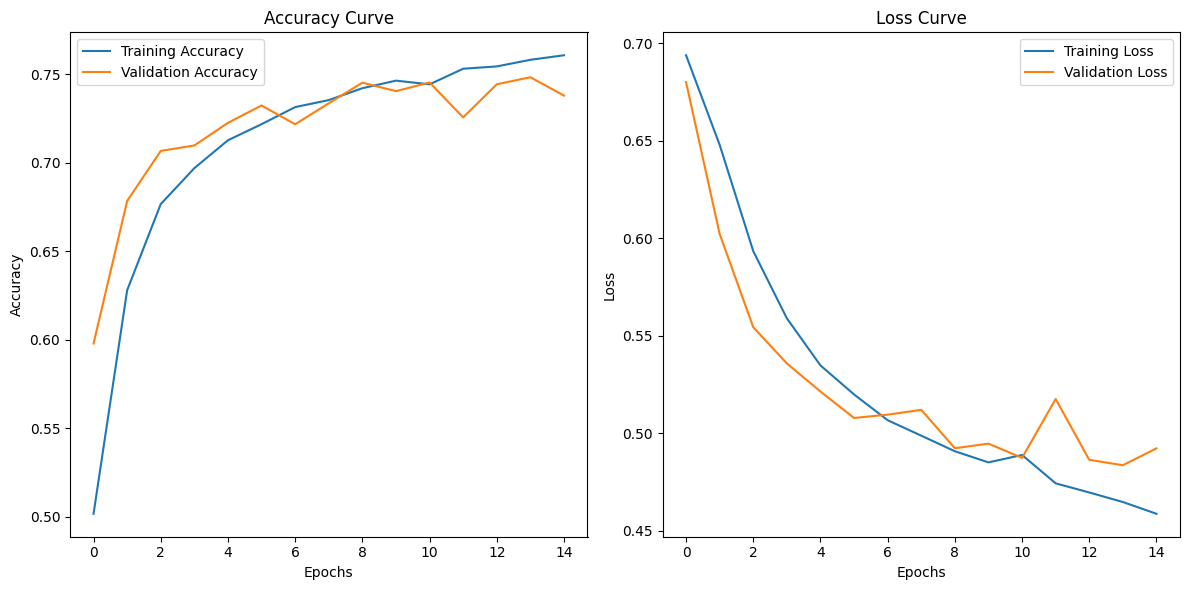

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

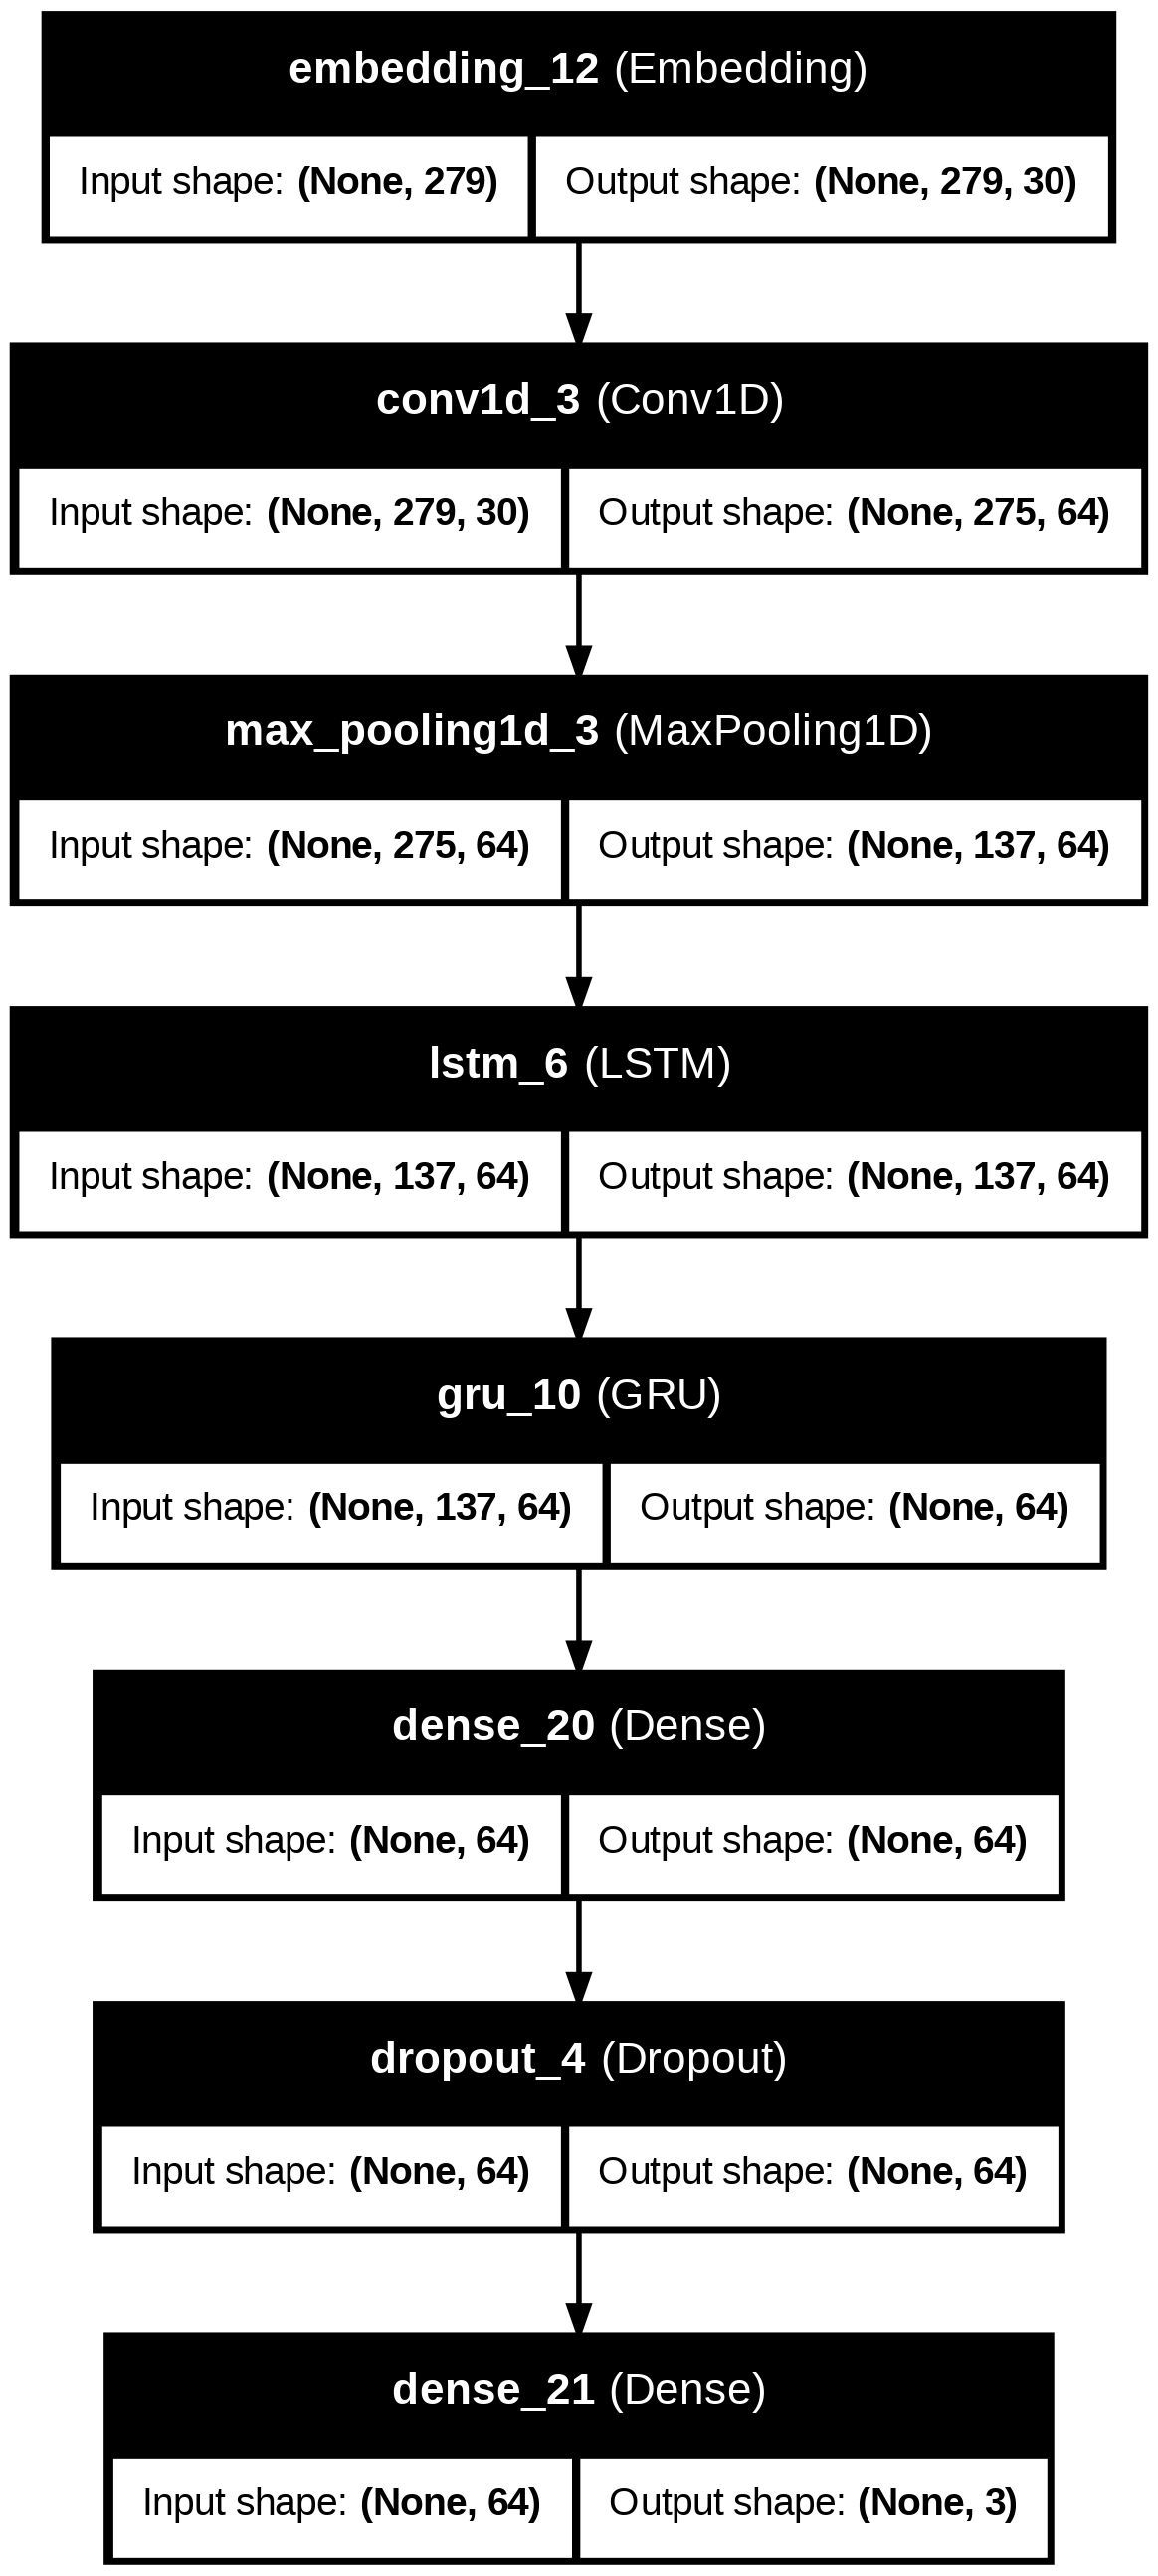

In [ ]:
from tensorflow.keras.utils import plot_model  # Import plot_model function



plot_model(model_cnn_lstm_gru, to_file='model_cnn_lstm_gru.png', show_shapes=True, show_layer_name =True)

BI-GRU

In [ ]:
# After implementing BiLSTM, you can switch to GRU as follows:

from tensorflow.keras.layers import GRU

# Build the GRU model
model_gru = Sequential()
model_gru.add(Embedding(input_dim=embedding_matrix.shape[0], output_dim=30, weights=[embedding_matrix], input_length=X.shape[1], trainable=False))
model_gru.add(Bidirectional(GRU(64)))  # Replace BiLSTM with BiGRU
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(y_train.shape[1], activation='sigmoid'))

# Compile the model
model_gru.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# Train the model
history= model_gru.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss_gru, accuracy_gru = model_gru.evaluate(XX_test, yy_test)
print(f'Loss (GRU): {loss_gru}, Accuracy (GRU): {accuracy_gru}')


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.6533 - loss: 0.6136 - val_accuracy: 0.5974 - val_loss: 0.7009
Epoch 2/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - accuracy: 0.7253 - loss: 0.5054 - val_accuracy: 0.7458 - val_loss: 0.4829
Epoch 3/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.7503 - loss: 0.4779 - val_accuracy: 0.7453 - val_loss: 0.4932
Epoch 4/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.7555 - loss: 0.4692 - val_accuracy: 0.7453 - val_loss: 0.4664
Epoch 5/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.7610 - loss: 0.4532 - val_accuracy: 0.7391 - val_loss: 0.4715
Epoch 6/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.7671 - loss: 0.4508 - val_accuracy: 0.7528 - val_loss: 0.4646
Epoch 7/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.7745 - loss: 0.4409 - val_accuracy: 0.7640 - val_loss: 0.4464
Epoch 8/15
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.7811 - loss: 0.43

In [ ]:
from sklearn.metrics import classification_report
# Step 10: Predict and calculate precision, recall, F1 score
y_pred = model_gru.predict(XX_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot predictions to class labels
y_true_classes = np.argmax(yy_test, axis=1)  # Convert one-hot ground truth to class labels
print(f"Accuracy: {accuracy_gru:.4f}")
# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, digits=4))

272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy: 0.7420

Classification Report:

              precision    recall  f1-score   support

           1     0.5907    0.8237    0.6880      3000
           2     0.8825    0.6989    0.7800      5685

    accuracy                         0.7420      8685
   macro avg     0.7366    0.7613    0.7340      8685
weighted avg     0.7817    0.7420    0.7482      8685



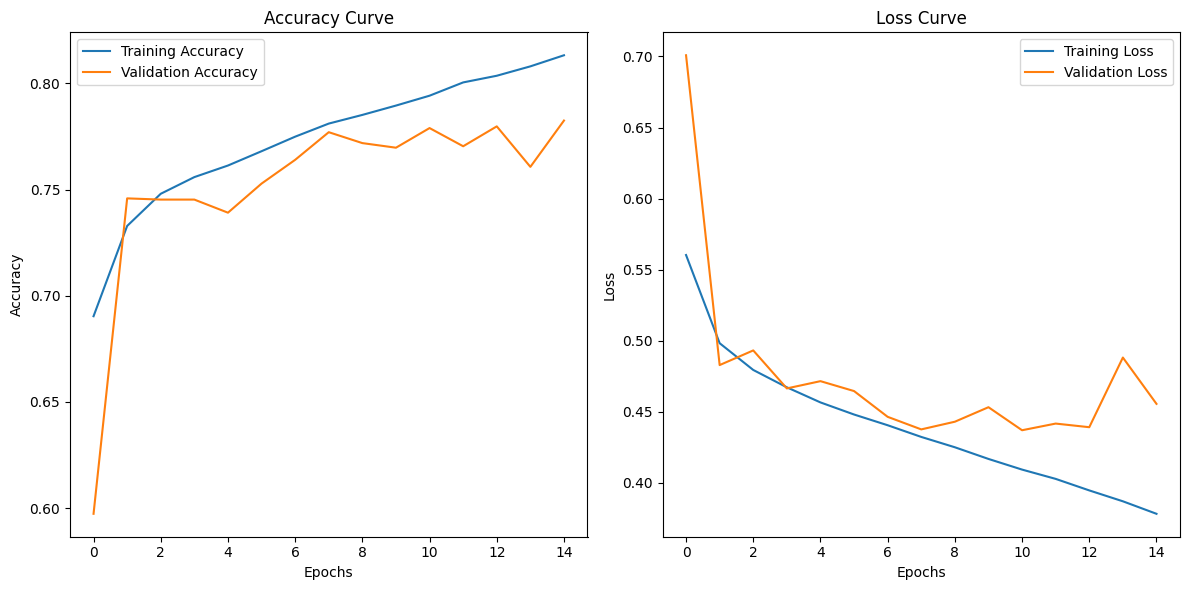

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()